In [1]:
import os
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from src.models.train_model import MonteCarloDropout, MCLSTM

In [118]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['science', 'notebook', 'grid', 'bright'])

In [45]:
model_name = r"merged-ce-mc.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\processed"
model_path = os.path.join(model_path, model_name)
model = keras.models.load_model(model_path, custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

with open(os.path.join(load_path, "processed_data.pickle"), "rb") as handle:
    combined_data = pickle.load(handle)

y_test = combined_data['y_test']
y_train = combined_data['y_train']

event_X_train = combined_data['event_X_train']
object_X_train = combined_data['object_X_train']

event_X_test = combined_data['event_X_test']
object_X_test = combined_data['object_X_test']

In [46]:
from src.features.build_features import scale_event_data, scale_object_data

event_X_train, event_X_test = scale_event_data(event_X_train, event_X_test)
object_X_train, object_X_test = scale_object_data(object_X_train, object_X_test)

In [134]:
def generate_sample():
    """select a random event from the test set with equal probability 
    of signal or background and return it with the corresponding label"""
    event_type = np.random.choice([0, 1])
    y_true = -1

    while y_true != event_type:
        n = np.random.randint(0, event_X_test.shape[0])
        sample = [event_X_test.iloc[n:n+1].values, object_X_test[n:n+1]]
        y_true = y_test.iloc[n:n+1].values
        y_true = y_true[0]

    return (sample, y_true)


def predict_dist(X, model, n_models):
    """predict the same event n times and return the distribution"""
    preds = [model(X, training=False) for _ in tqdm(range(n_models))]
    return np.hstack(preds)


def plot_dist(sample, model, n_models, y_true):
    """plot the distribution of the predictions for a given event"""
    y_pred_dist = predict_dist(sample, model, n_models)
    y_pred = y_pred_dist.mean(axis=1)

    event_type = 'Signal' if y_true == 1 else 'Background'
    plt.xlim([0, 1])
    plt.xlabel('Discriminator Output')
    plt.title(f'Prediction Distribution for a Random {event_type} Event')
    sns.kdeplot(y_pred_dist[0], shade=True)
    plt.axvline(y_pred[0])
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.tight_layout()
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

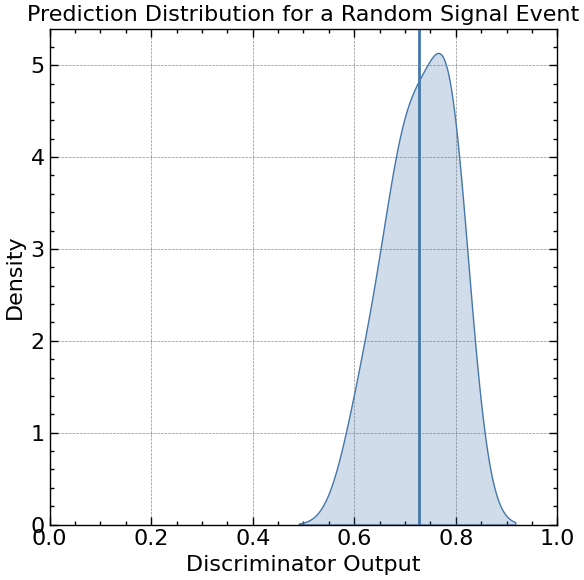

In [135]:
n_models = 10

sample, y_true = generate_sample()
plot_dist(sample, model, n_models, y_true)

In [95]:
def predict_sample(X, model, n_models):
    preds = [model(X, training=False) for _ in range(n_models)]
    mean = np.mean(preds)
    std = np.std(preds)
    return (mean, std)

def make_error_df(errors, true_vals):
    error_df = pd.DataFrame(errors, columns=['Discriminator Output', 'Standard Deviation (σ)'])
    error_df['event type'] = [i for i in true_vals]
    error_df['Prediction Error'] = np.abs(error_df['Discriminator Output'] - error_df['event type'])
    error_df.replace(to_replace=[0, 1], value=['background', 'signal'], inplace=True)
    return error_df

In [49]:
n_samples = 1000
n_models = 10
errors, true_vals = [], []

for _ in tqdm(range(n_samples)):
    sample, y_true = generate_sample()
    true_vals.append(y_true)
    error = predict_sample(sample, model, n_models)
    errors.append(error)

error_df = make_error_df(errors, true_vals)

  0%|          | 0/1000 [00:00<?, ?it/s]

Average Uncertainty: 0.0363
Correlation Between Predicted Error and Actual Error based on MC Dropout: 0.3371


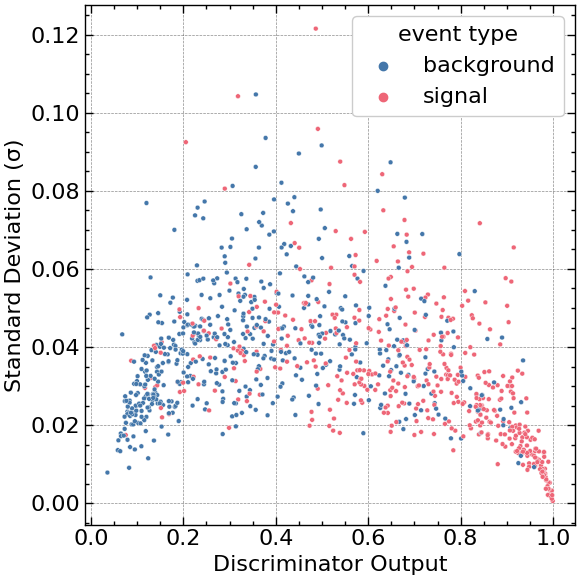

In [125]:
def plot_output_error(error_df):
    sns.scatterplot(x='Discriminator Output', 
                    y='Standard Deviation (σ)', 
                    hue='event type', 
                    data=error_df, 
                    s=12, 
                    x_bins=10)
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.tight_layout()

average_std = np.mean(error_df['Standard Deviation (σ)'])
correlation = error_df['Prediction Error'].corr(error_df['Standard Deviation (σ)'])

print(f'Average Uncertainty: {average_std:.4f}\nCorrelation Between Predicted Error and Actual Error based on MC Dropout: {correlation:.4f}')
plot_output_error(error_df)

In [53]:
print(error_df[error_df['event type'] == 'background']['Prediction Error'].corr(error_df['std']))
print(error_df[error_df['event type'] == 'signal']['Prediction Error'].corr(error_df['std']))
print(error_df['Prediction Error'].corr(error_df['std']))


0.1339164748148379
0.5029302325986791
0.3370977128727664


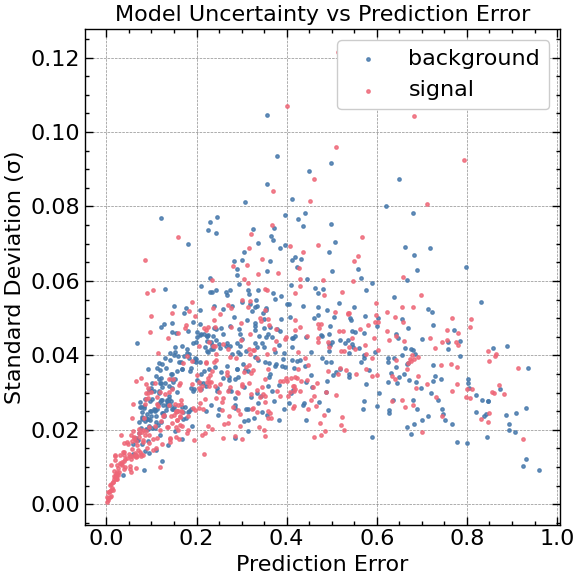

In [136]:
def plot_prediction_error(error_df):
    sns.lmplot(x='Prediction Error',
               y='Standard Deviation (σ)',
               hue='event type',
               data=error_df,
               scatter_kws={"s": 6},
               fit_reg=False,
               lowess=False,
               legend=False,
               )
    plt.legend(loc='upper right')
    plt.title('Model Uncertainty vs Prediction Error')
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.tight_layout()

plot_prediction_error(error_df)

In [59]:
# calculates the correlation between predicted error and actual error without mc dropout as a comparison
predicted_errors = []
actual_errors = []
n_samples = 1000

# loads non-MC model
model_name = r"merged-ce.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"
model_path = os.path.join(model_path, model_name)
model_no_mc = keras.models.load_model(model_path, custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

for _ in tqdm(range(n_samples)):
    sample, y_true = generate_sample()
    pred = float(model_no_mc.predict(sample))
    predicted_error = 2 * (0.5 - np.abs(0.5 - pred))
    predicted_errors.append(predicted_error)

    if y_true == 1 and pred > 0.5 or y_true == 0 and pred < 0.5:
        actual_errors.append(0)
    else:
        actual_errors.append(1)

print(f'Correlation between Predicted Error and Actual Error based on Model Output: {np.corrcoef(predicted_errors, actual_errors)[0, 1]}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Correlation between Predicted Error and Actual Error based on Model Output: 0.2921132547348186
